# Project: Finding Lane Lines on the Road

## Import Packages

In [945]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


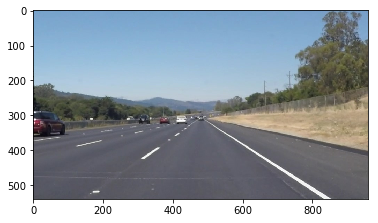

In [946]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Helper Functions

In [947]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

## Test Images

Let's build the pipeline to work on the images in the directory "test_images".

In [948]:
import os
os.listdir("test_images/")

['solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

## Build a Lane Finding Pipeline

Let's build the pipeline that will draw lane lines on the test_images and run the solution on all test_images. Copies of images will be placed into the  `test_images_output` directory.

In [1019]:
# from os.path import isdir
import os

output_dir = 'test_images_output/'
if not os.path.exists(output_dir):
        os.mkdir(output_dir)
!mkdir test_images_output

files = os.listdir("test_images/")

mkdir: test_images_output: File exists


In [1059]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

def display_images(images, cmap=None):
    cols = 2
    rows = (len(images) + 1) // cols
    plt.figure(figsize=(10, 11))
    for i in range(len(images)):
        plt.subplot(rows, cols, i + 1)
        image = images[i]
        cmap = 'gray' if len(image.shape)==2 else cmap
        plt.imshow(image, cmap=cmap)
        plt.xticks([])
        plt.yticks([])
    plt.tight_layout(pad=0, h_pad=-10, w_pad=0)
    plt.show()

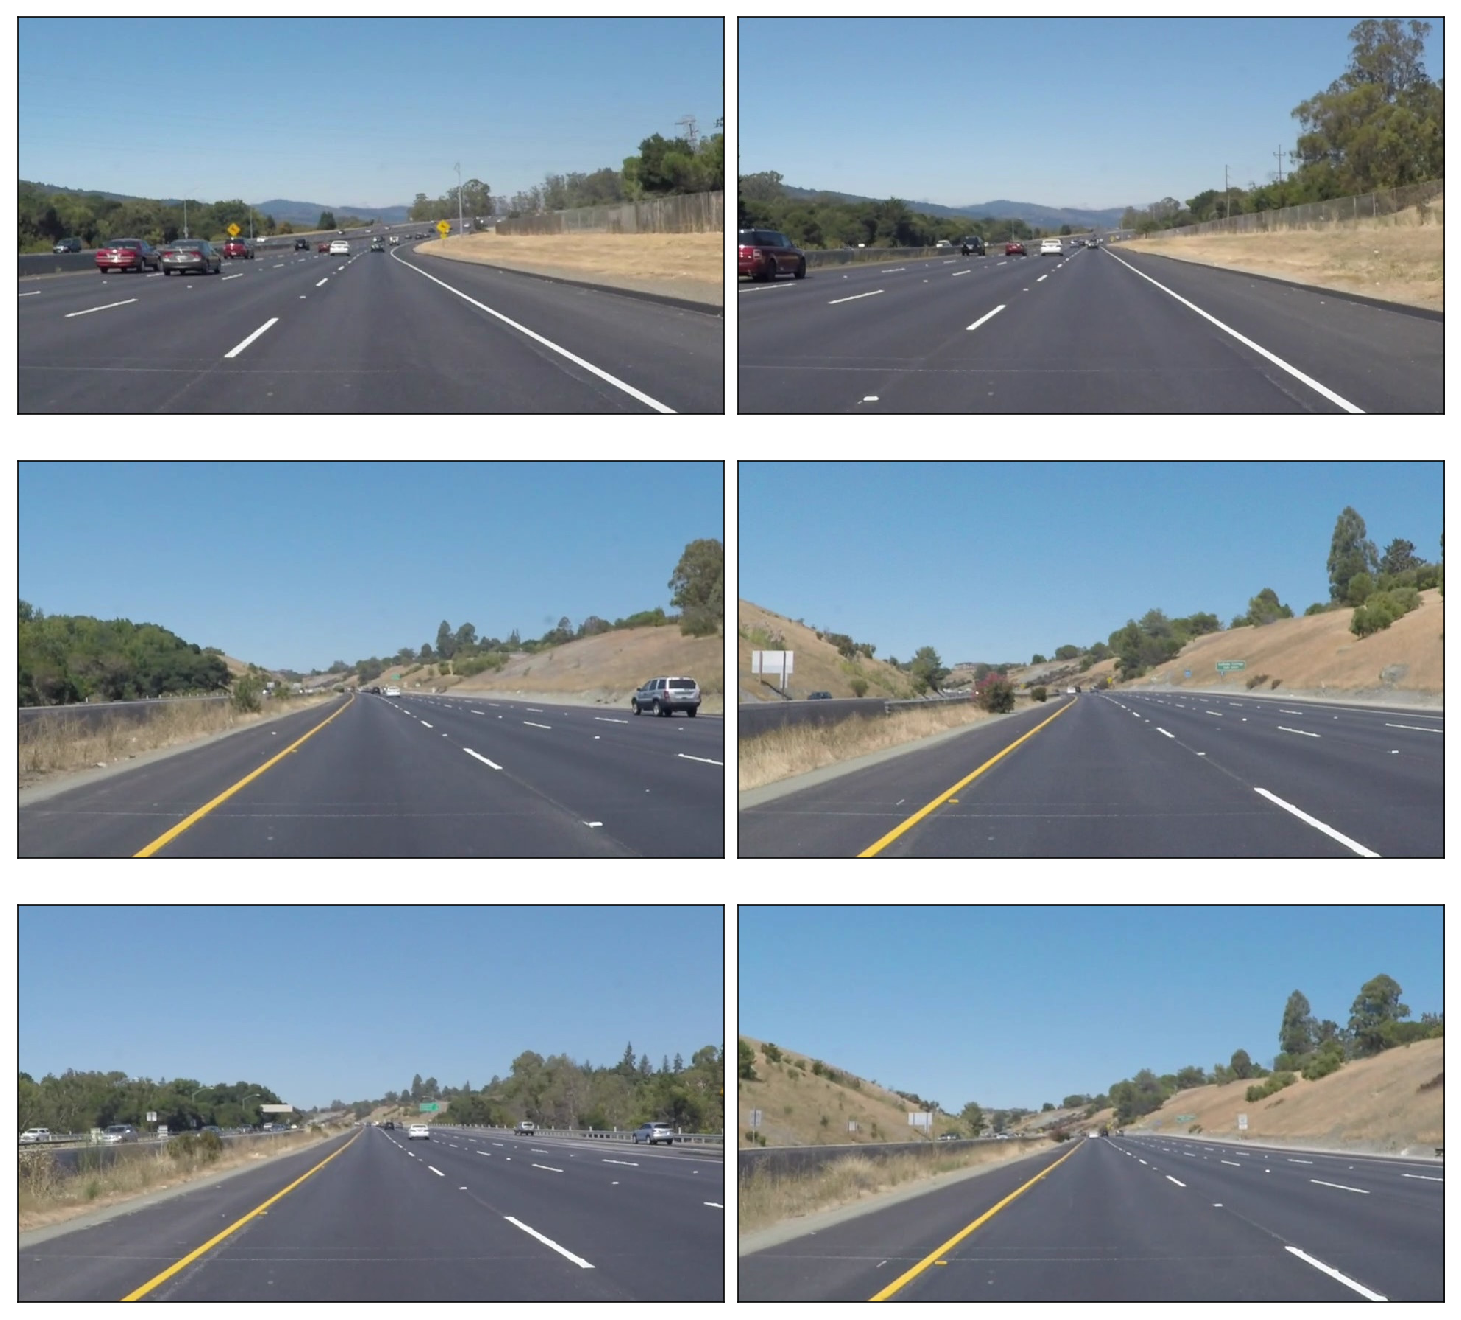

In [1060]:
images = [mpimg.imread('test_images/' + filename) for filename in files]
display_images(images)

### Color extraction

In [1077]:
# select only lines of white & yellor colors using a simple color range extraction
def extract_yellor_and_white(image):
    # white color mask
    lower = np.uint8([200, 200, 200])
    upper = np.uint8([255, 255, 255])
    white_mask = cv2.inRange(image, lower, upper)
    # yellow color mask
    lower = np.uint8([190, 190,   0])
    upper = np.uint8([255, 255, 204])
    yellow_mask = cv2.inRange(image, lower, upper)
    # combine the mask
    mask = cv2.bitwise_or(white_mask, yellow_mask)
    masked = cv2.bitwise_and(image, image, mask = mask)
    return masked

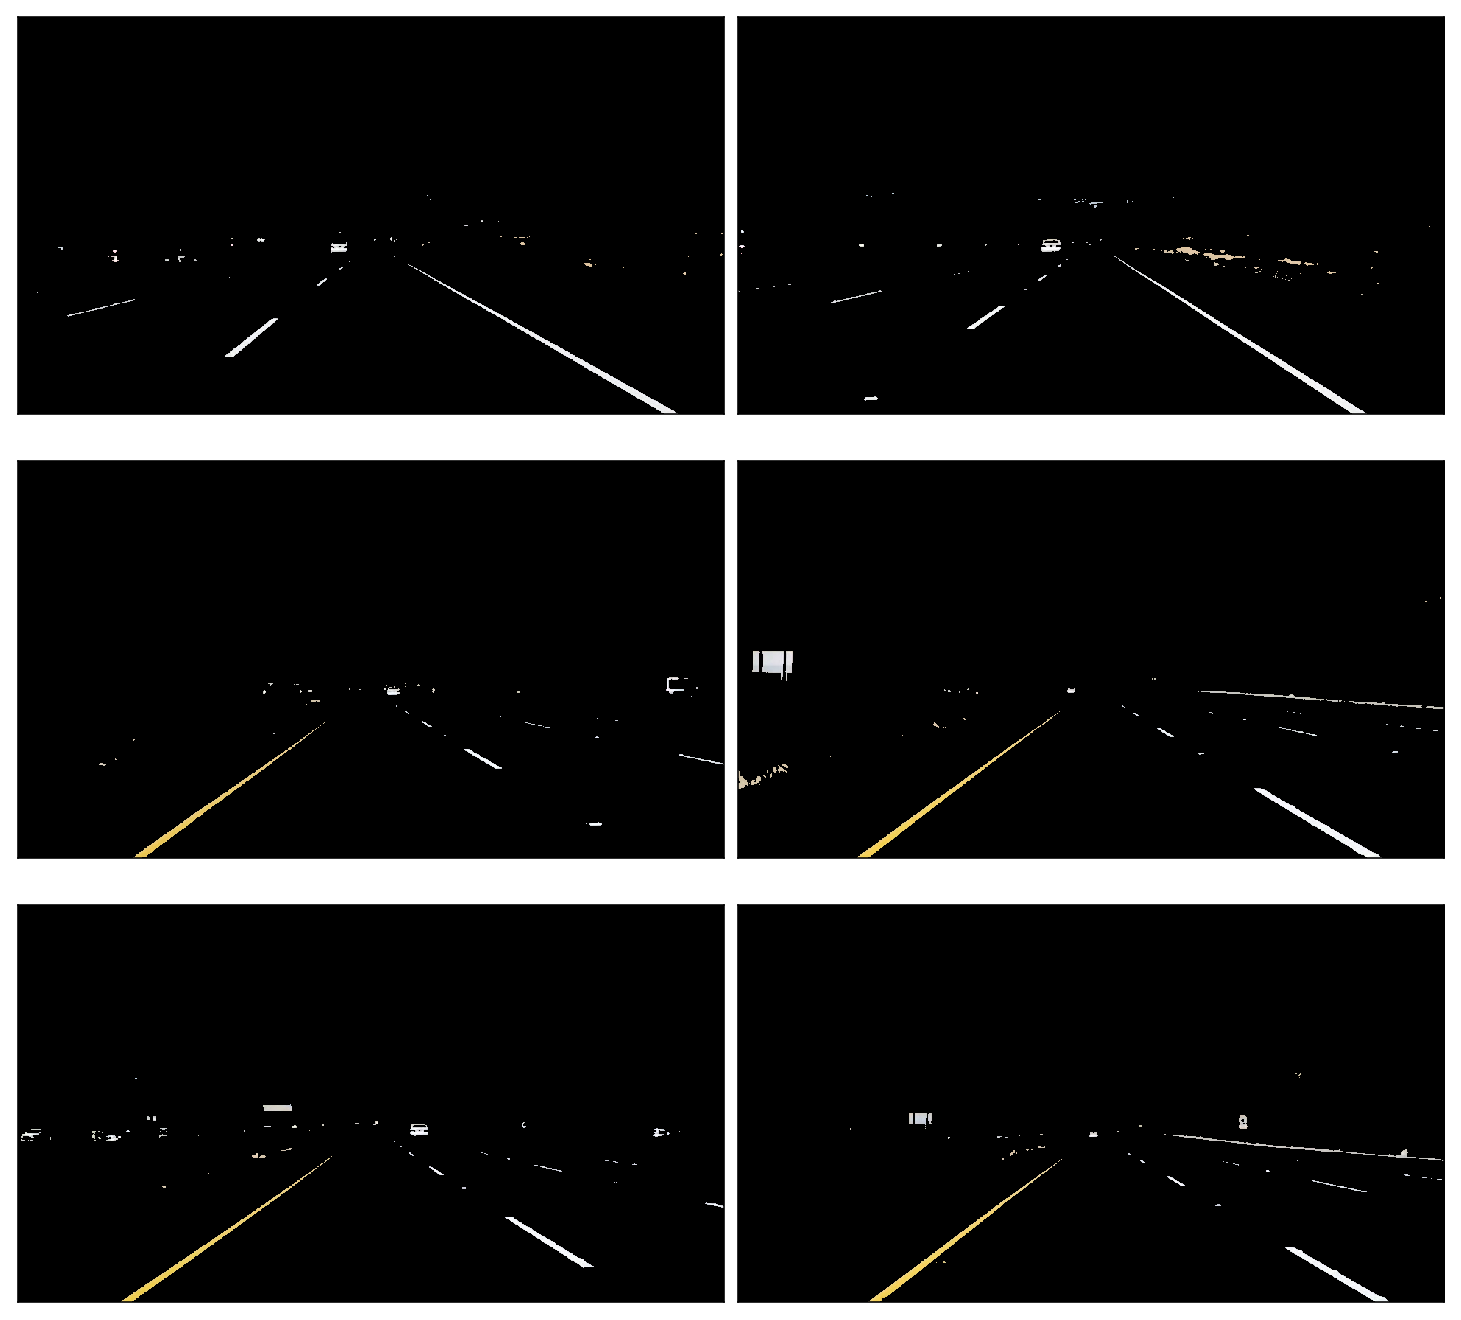

In [1076]:
images = [mpimg.imread('test_images/' + filename) for filename in files]
color_masked_images = []
for image in images:
    masked  = extract_yellor_and_white(image)
    color_masked_images.append(masked)
    
display_images(color_masked_images)

### Grayscaling

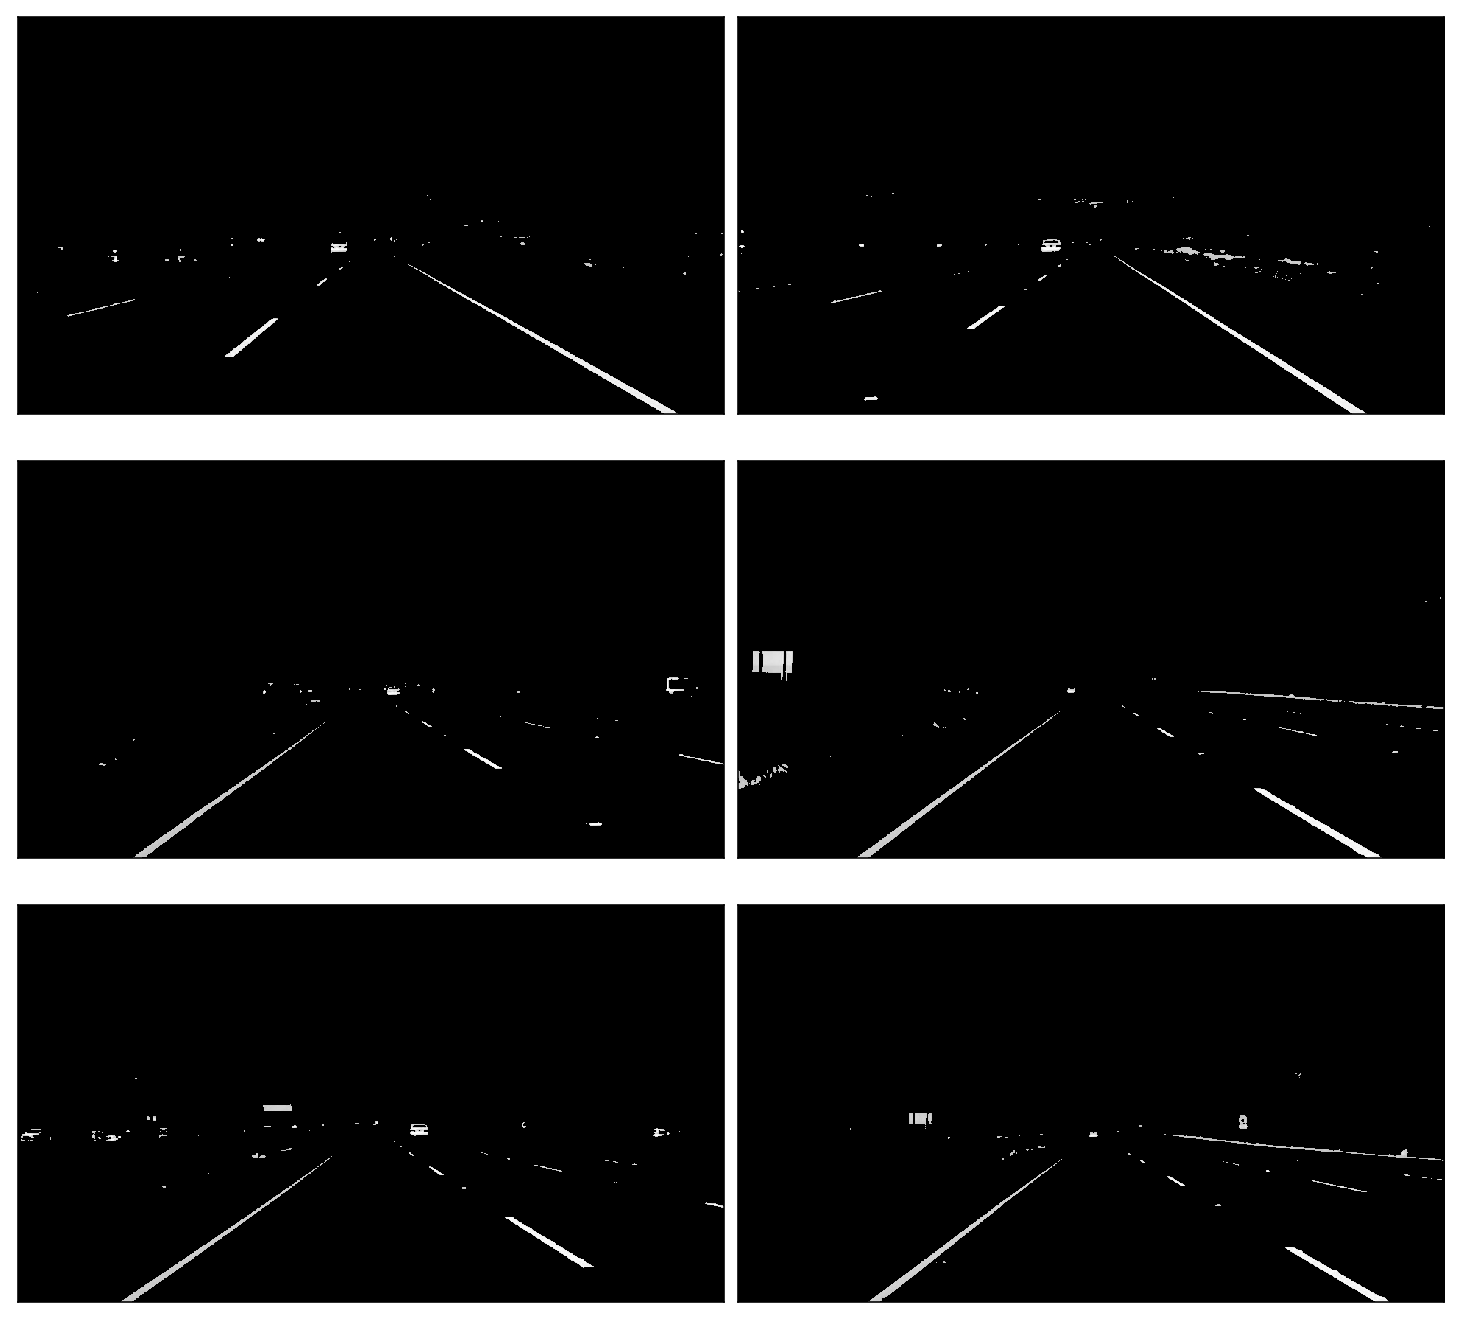

In [1078]:
# grayscale each image
gray_images = list(map(grayscale, color_masked_images))
display_images(gray_images)

### Smoothing

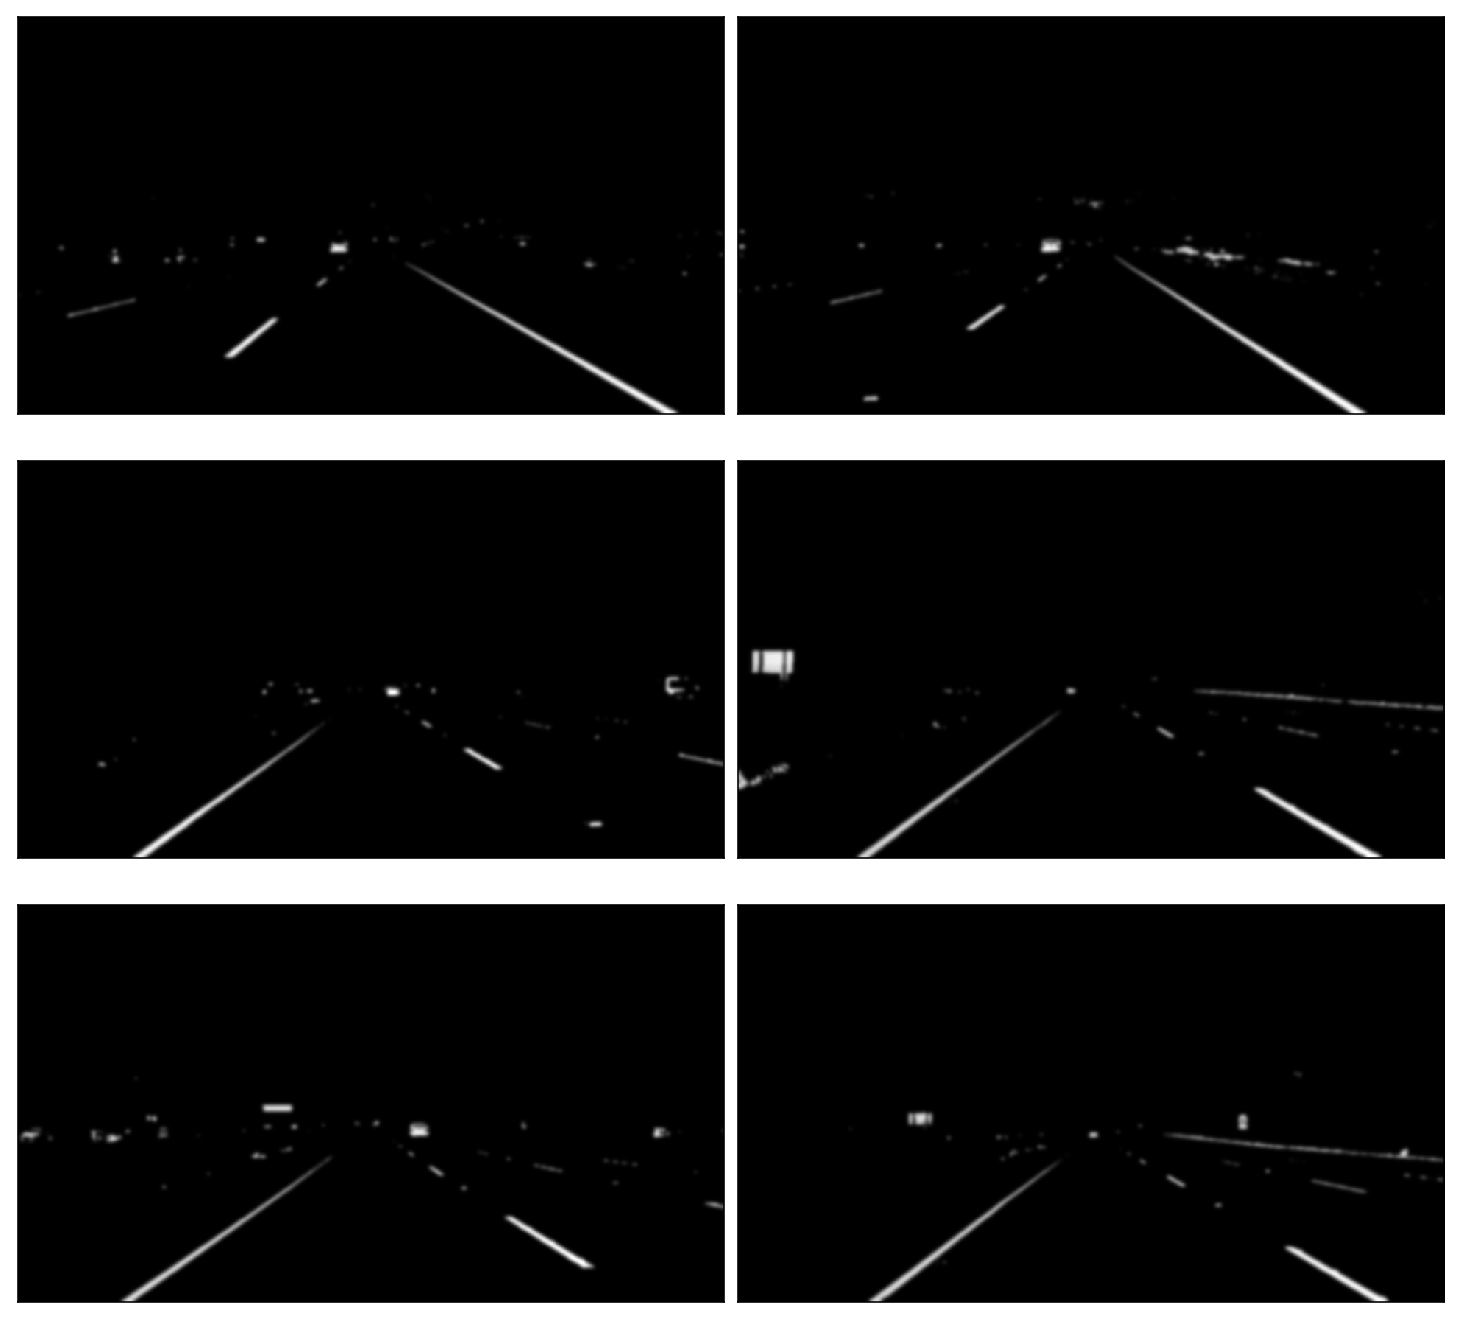

In [1127]:
# Define a kernel size and apply Gaussian smoothing
kernel_size = 15
blur_gray = list(map(lambda image: gaussian_blur(image, kernel_size), gray_images))
display_images(blur_gray)

### Edges detection

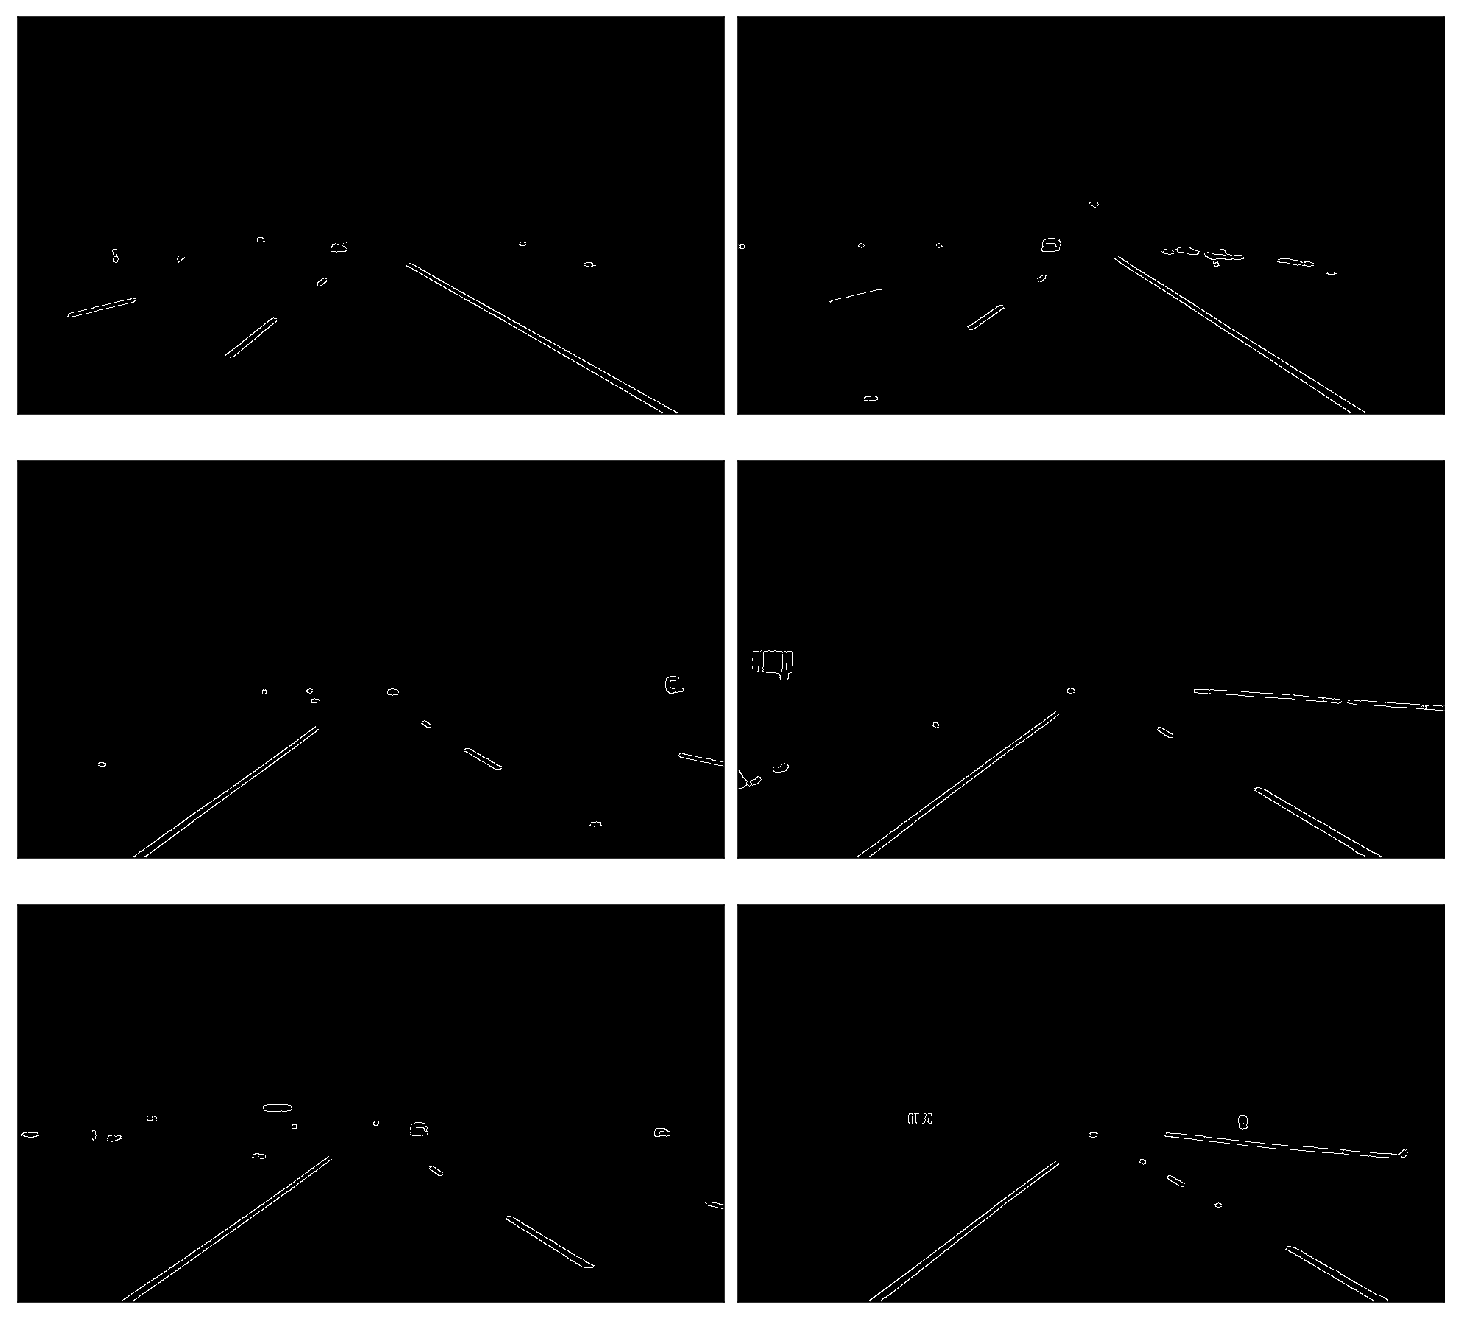

In [1128]:
# Define our parameters for Canny and apply
low_threshold = 50
high_threshold = 150
edges = list(map(lambda image: canny(image, low_threshold, high_threshold), blur_gray))
display_images(edges)

### Region of interest

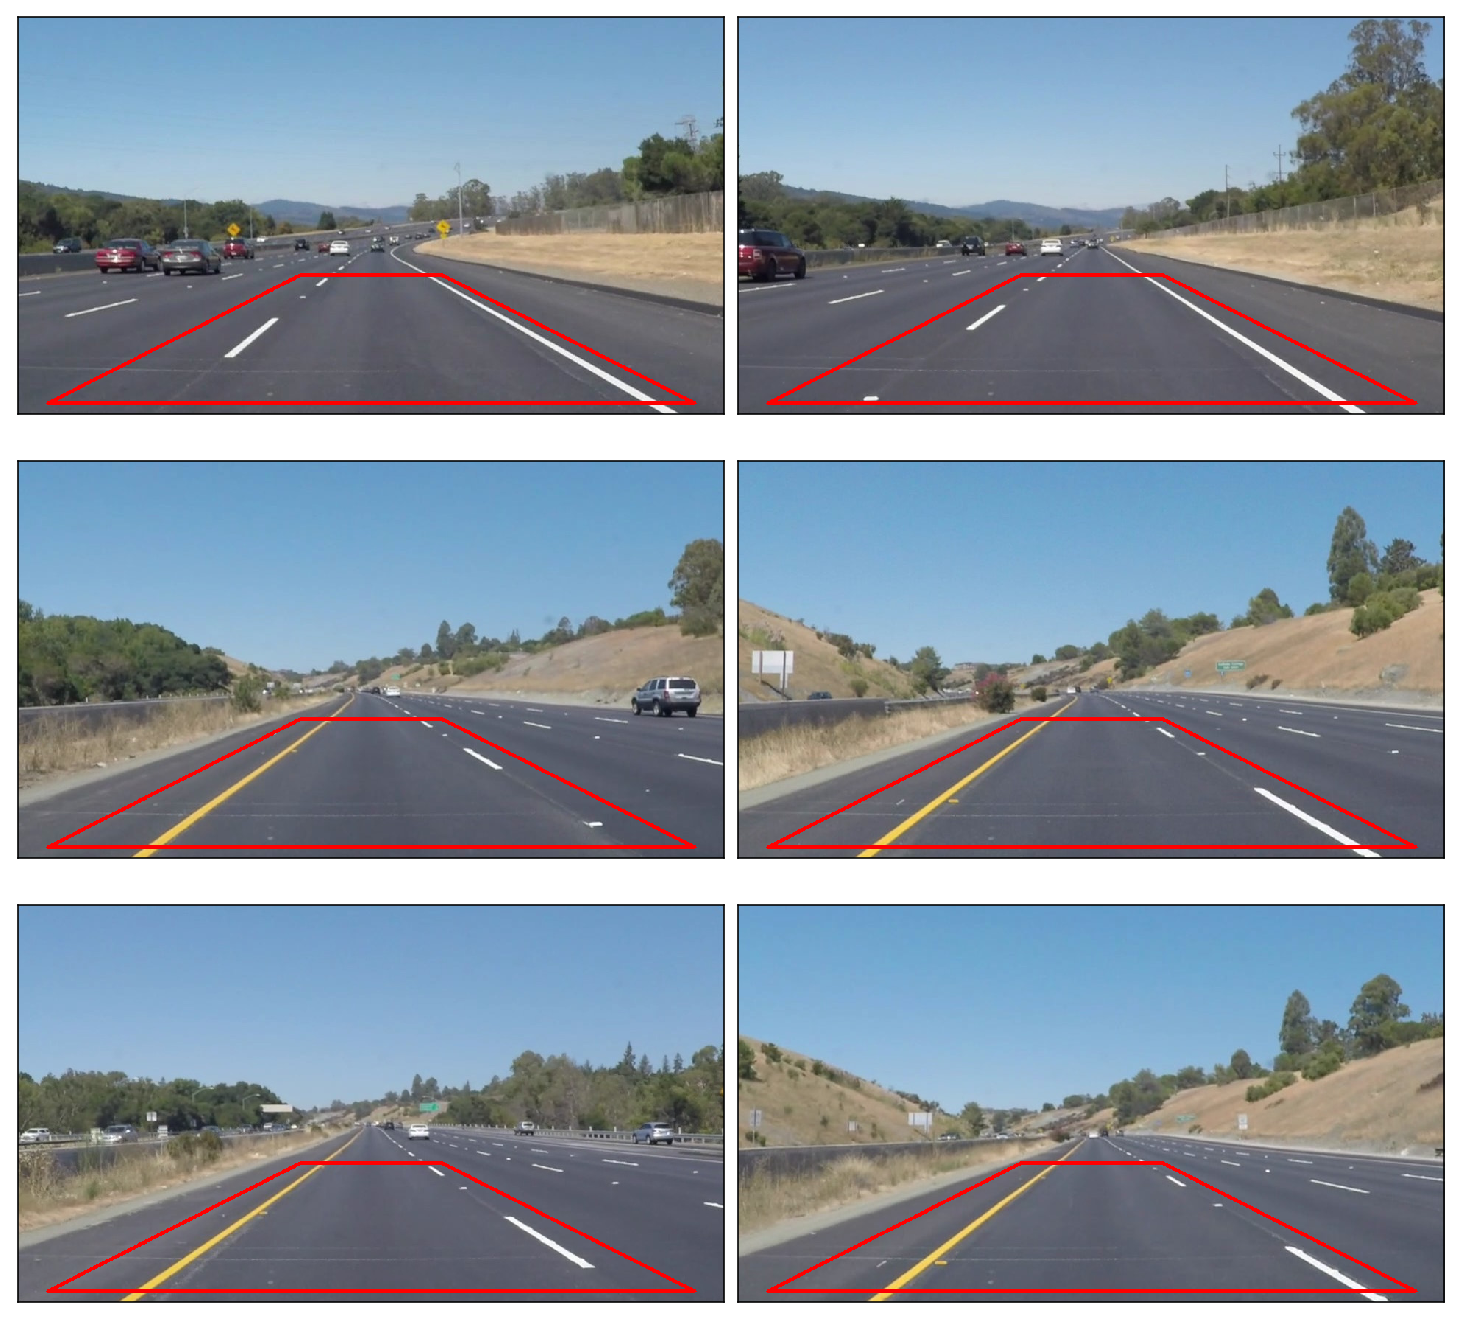

In [1141]:
# as ROI, let's define a four sided polygon to mask
roi = []
all_vertices = []
for image in images:
    imshape = image.shape
    vertices = np.array([[(40,imshape[0] - 15), 
                          (imshape[1] * 0.4, imshape[0] * 0.65),
                          (imshape[1] * 0.6, imshape[0] * 0.65), 
                          (imshape[1] - 40,imshape[0] - 15)]], dtype=np.int32)
    all_vertices.append(vertices)
    
    copy_color_img = image.copy()
    cv2.polylines(copy_color_img,[vertices], True,(255, 0, 0), thickness=4)
    roi.append(copy_color_img)

display_images(roi)

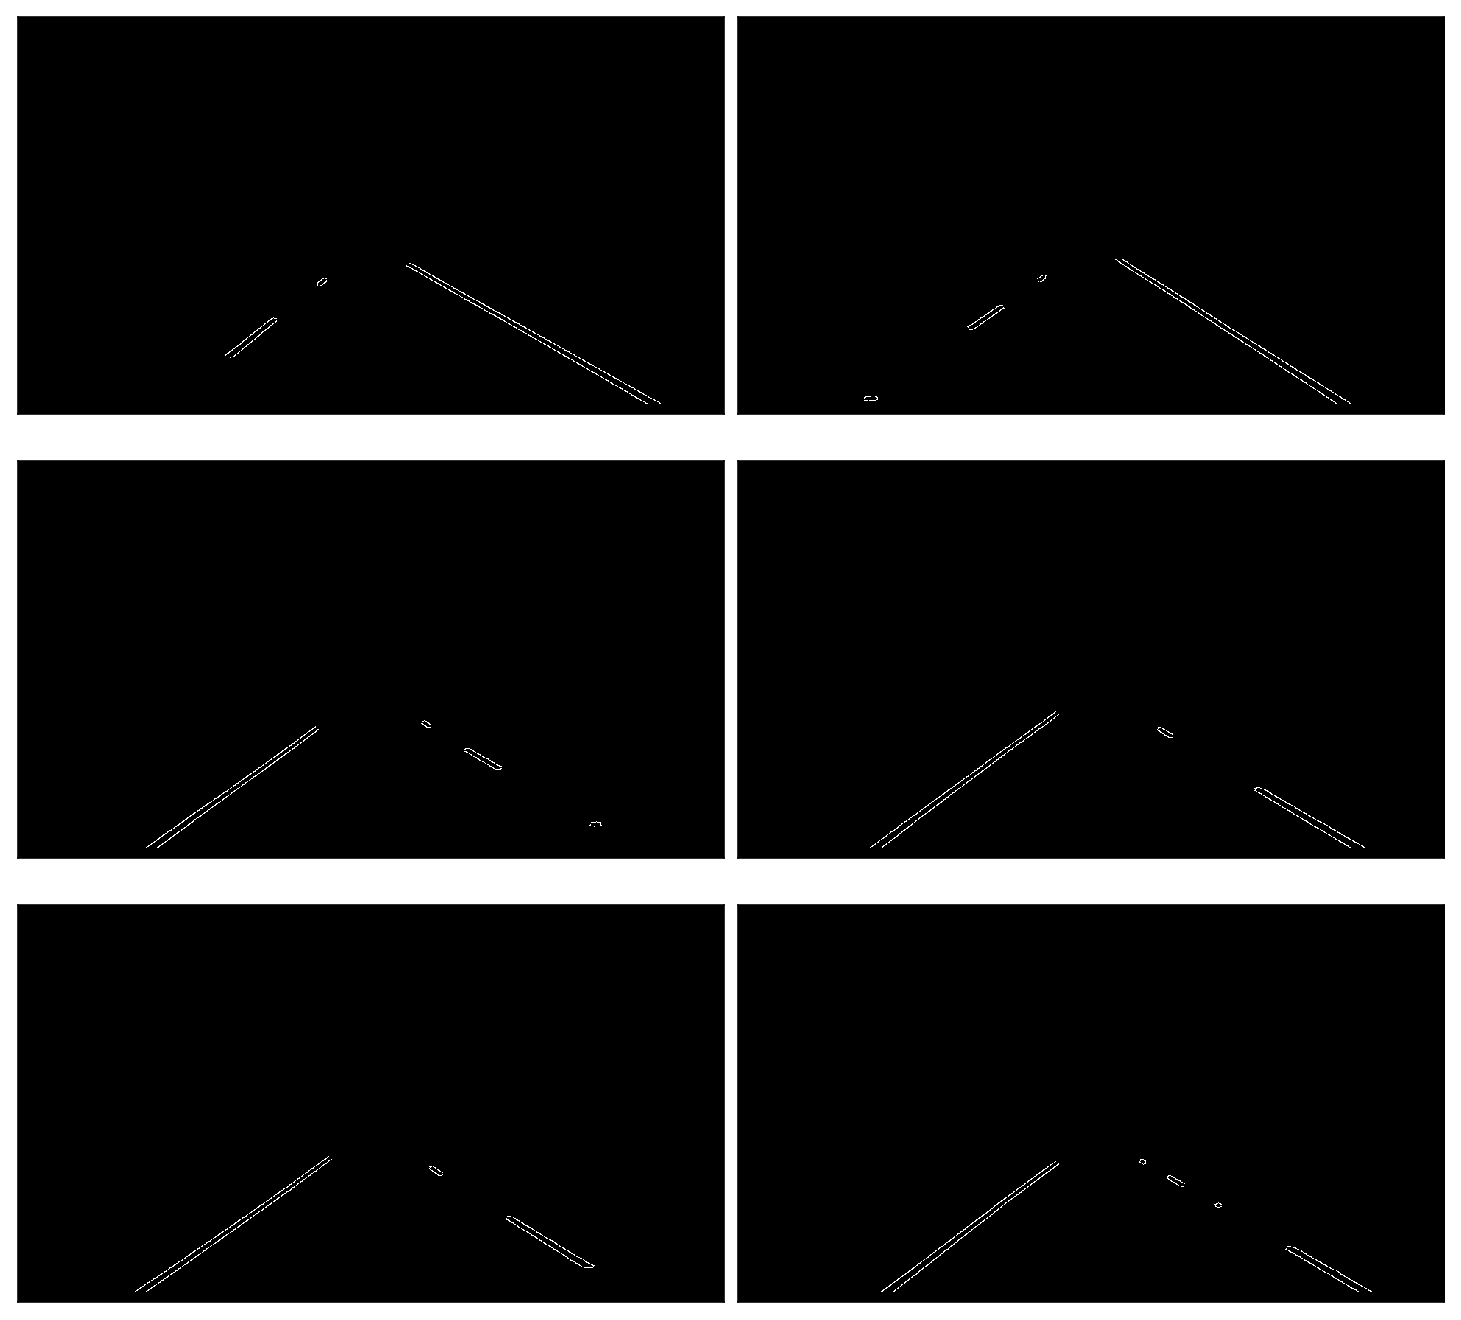

In [1130]:
masked_edges = []
for i in range(len(edges)):
    image_canny = edges[i]
    vertices = all_vertices[i]
    roi = region_of_interest(image_canny, vertices)
    masked_edges.append(roi)
    
display_images(masked_edges)

### Hough transform to find lanes

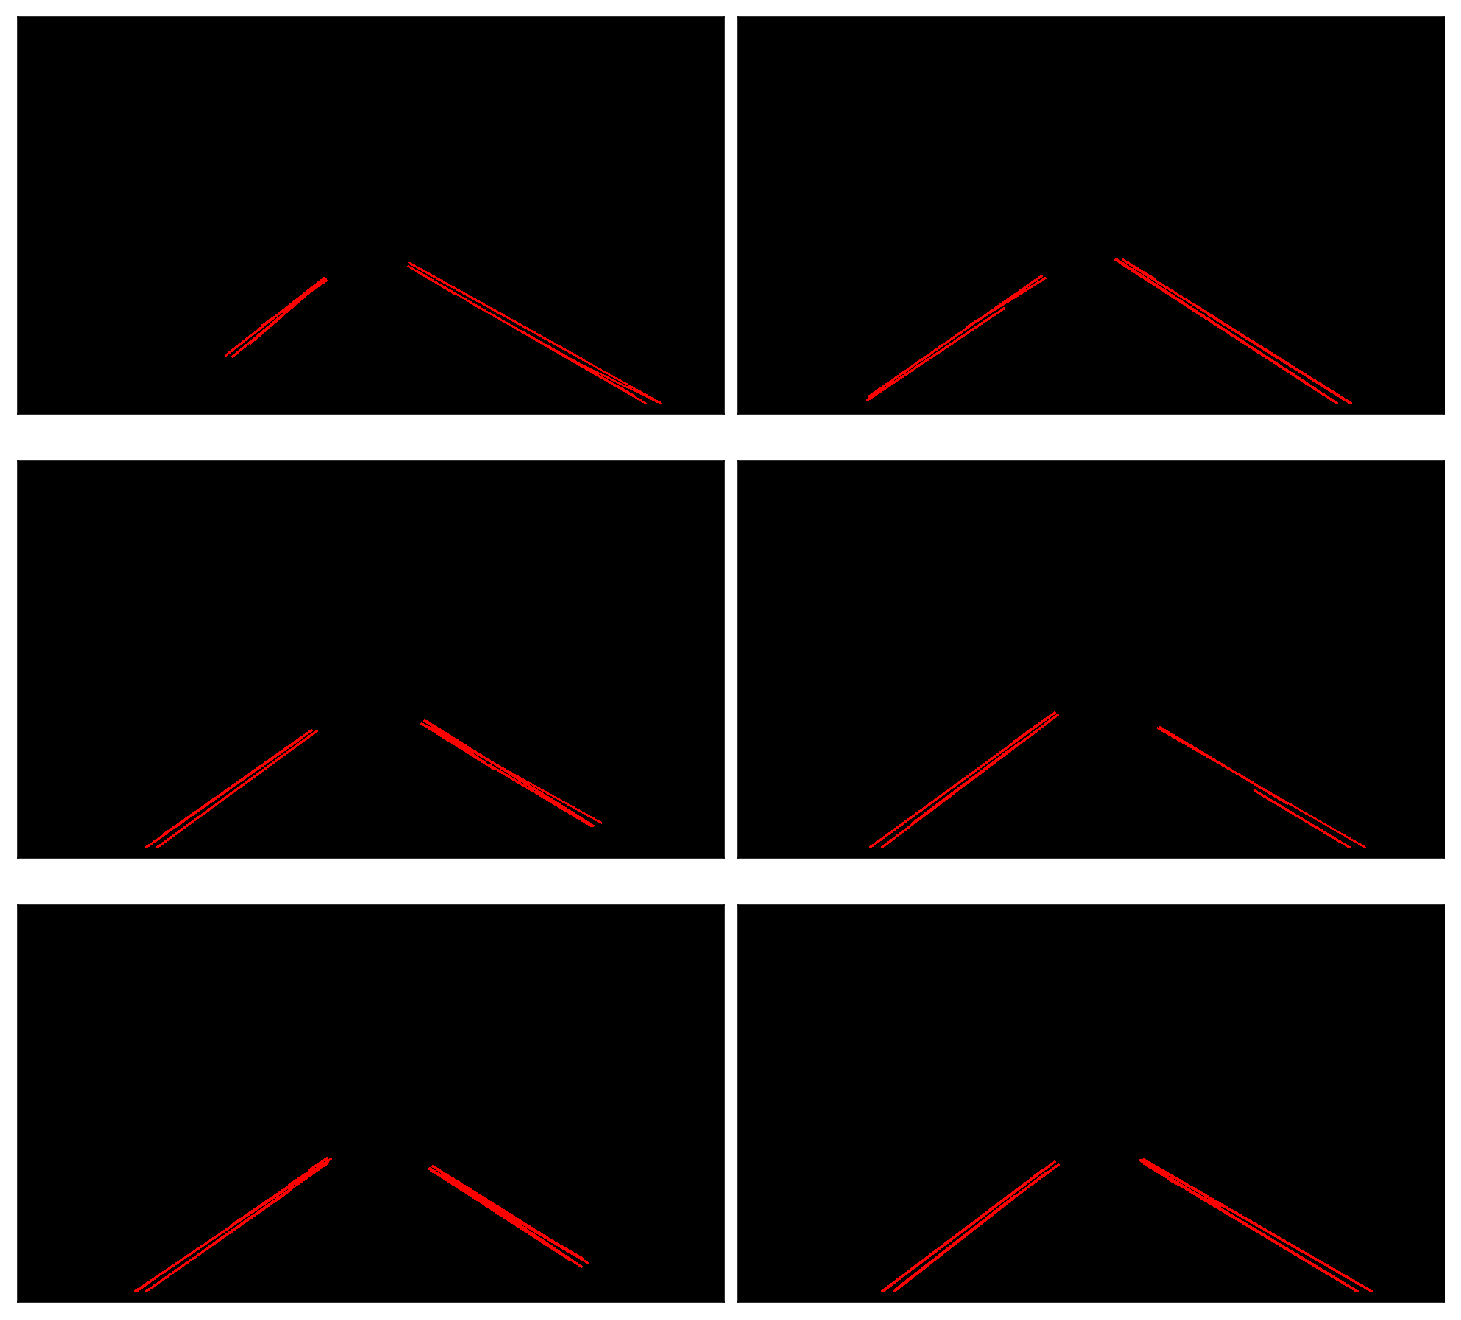

In [1131]:
# Define the Hough transform parameters
rho = 2 # distance resolution in pixels of the Hough grid
theta = np.pi/180 # angular resolution in radians of the Hough grid
threshold = 30     # minimum number of votes (intersections in Hough grid cell)
min_line_length = 20 #minimum number of pixels making up a line
max_line_gap = 200   # maximum gap in pixels between connectable line segments

lines = list(map(lambda image: hough_lines(image, rho, theta, threshold, min_line_length, max_line_gap), 
                 masked_edges))
display_images(lines)

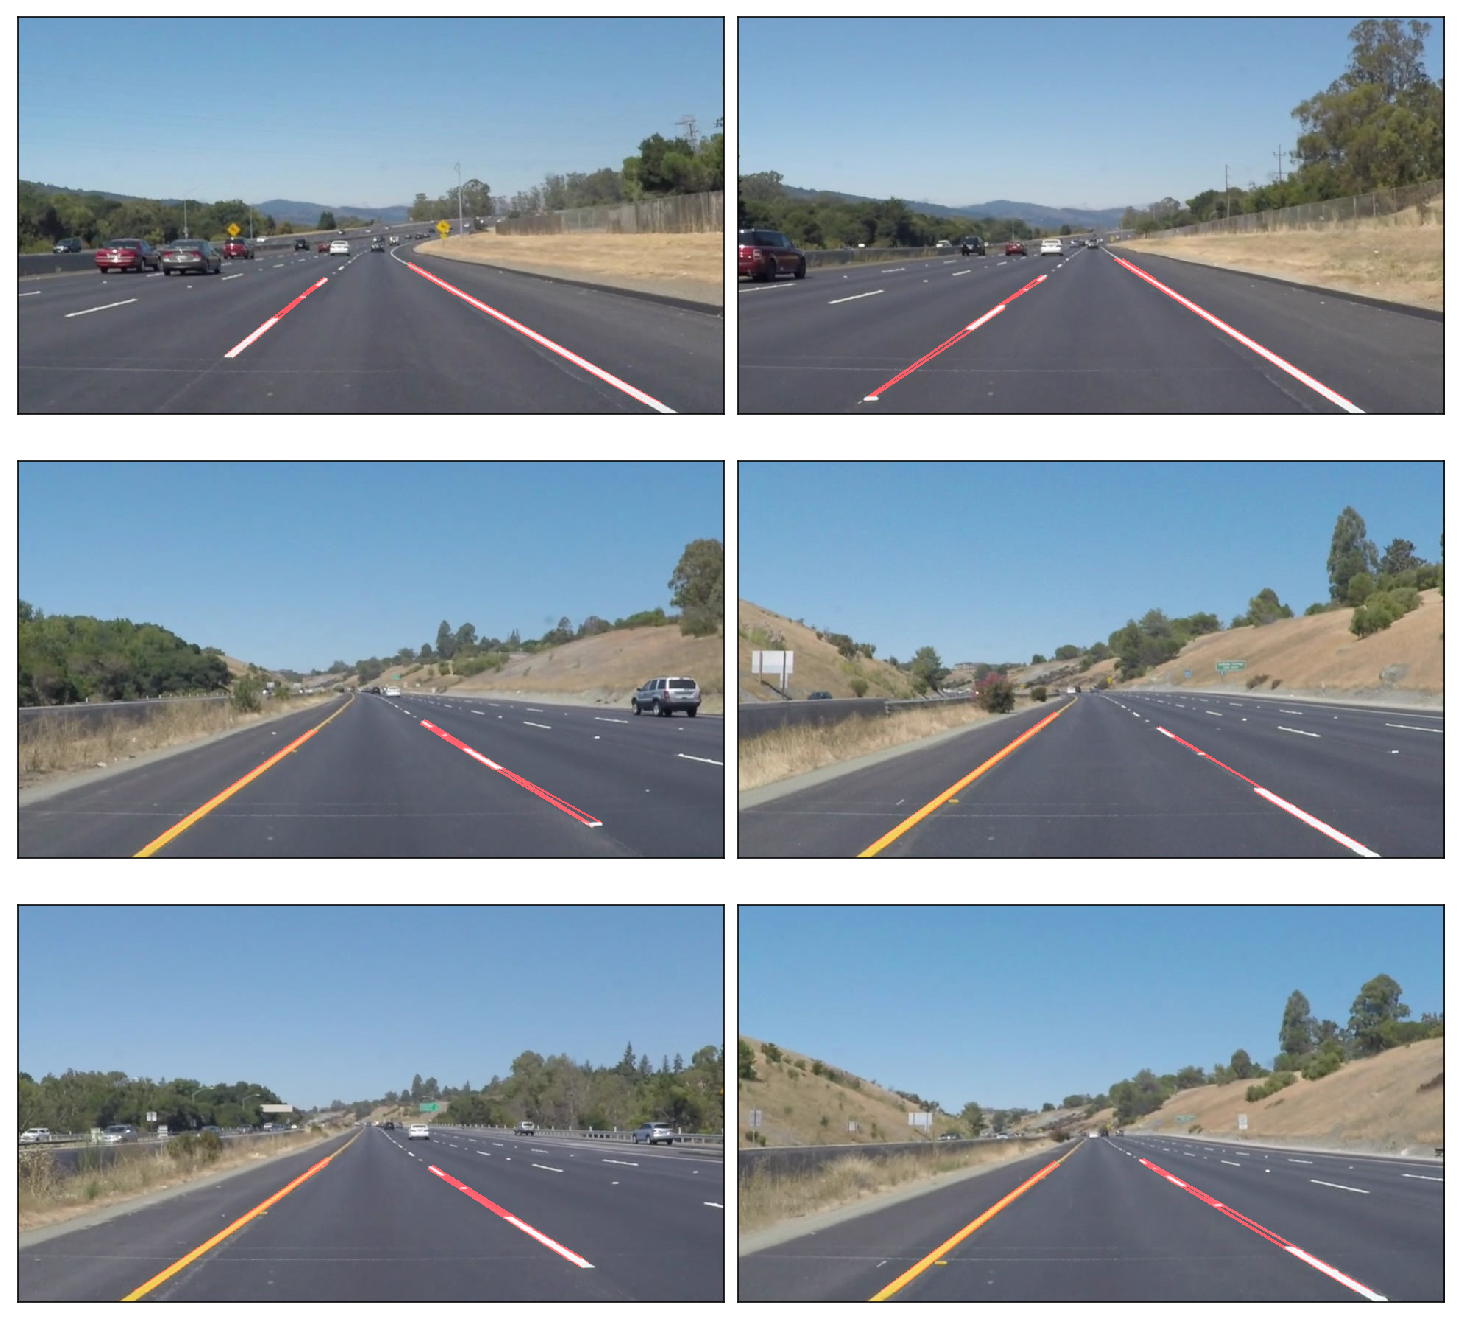

In [1132]:
# Draw lines on the initial images
images_lines = []
for i in range(len(images)):
    copy_color_img = images[i].copy()
    line = lines[i]
    # Draw the lines on the edge image
    color_lines = weighted_img(copy_color_img, line)
    images_lines.append(color_lines)
    
    #save onto the disk
    filename = files[i] 
#     output_path = output_dir + filename[:-4] 
#     if not os.path.exists(output_path):
#         os.mkdir(output_path)
#     mpimg.imsave(output_path + "/lines_color.jpg", color_lines)
    mpimg.imsave(output_dir + filename, color_lines)

display_images(images_lines)

## Test on Videos

Let's draw lines over video. 
Let's test the solution on two provided videos:

solidWhiteRight.mp4

solidYellowLeft.mp4

If you get an error that looks like this:
```
NeedDownloadError: Need ffmpeg exe. 
```
You can download it by calling: 
```
imageio.plugins.ffmpeg.download()
```
Follow the instructions in the error message and check out this [forum](https://discussions.udacity.com/t/project-error-of-test-on-videos/274082) post for more troubleshooting tips across operating systems.

In [1013]:
# import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [1137]:
def process_image(image):
    # NOTE: The output should be a color image (3 channel) for processing video below
    # we should return the final output (image where lines are drawn on lanes)
    # extract the white and yellow lines
    color_masked = extract_yellor_and_white(image)
    
    # Read in and grayscale the image
    gray = grayscale(color_masked)
    
    # Define a kernel size and apply Gaussian smoothing
    kernel_size = 15
    blur_gray = gaussian_blur(gray, kernel_size)

    # Define our parameters for Canny and apply
    low_threshold = 50
    high_threshold = 150
    edges = canny(blur_gray, low_threshold, high_threshold)
    
    # as ROI, let's define a four sided polygon to mask
    imshape = image.shape
    vertices = np.array([[(40,imshape[0] - 15), 
                          (imshape[1] * 0.6, 330),
                          (imshape[1] * 0.6, 330), 
                          (imshape[1] - 40,imshape[0] - 15)]], dtype=np.int32)
    
    # let's create a masked edges image
    masked_edges = region_of_interest(edges, vertices)
    
    # Define the Hough transform parameters
    rho = 2 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 30     # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 20 #minimum number of pixels making up a line
    max_line_gap = 200    # maximum gap in pixels between connectable line segments
    line_img = hough_lines(masked_edges, rho, theta, threshold, min_line_length, max_line_gap)
    
    # Create a color copy of the initial image to combine with line image
    copy_color_img = image.copy()

    # Draw the lines on the edge image
    result = weighted_img(copy_color_img, line_img)
    return result

Let's try the one with the solid white lane on the right first ...

In [1138]:
!mkdir test_videos_output
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

mkdir: test_videos_output: File exists
[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


100%|█████████▉| 221/222 [00:04<00:00, 54.85it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

CPU times: user 3.83 s, sys: 1.32 s, total: 5.15 s
Wall time: 4.5 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

**NOTE**: the video may fail to play in Safari but works well in Chrome.

In [929]:
HTML("""
<video width="960" height="540" controls>
  <source 
      src="{0}"
      type="video/mp4">
</video>
""".format(white_output))

In [1135]:
!mkdir test_videos_output
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
# clip1 = VideoFileClip("test_videos/solidYellowLeft.mp4").subclip(12,18)
clip1 = VideoFileClip("test_videos/solidYellowLeft.mp4")
yellow_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time yellow_clip.write_videofile(yellow_output, audio=False)

mkdir: test_videos_output: File exists
[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


100%|█████████▉| 681/682 [00:12<00:00, 61.42it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

CPU times: user 11.5 s, sys: 3.76 s, total: 15.3 s
Wall time: 13 s


## Improve the draw_lines() function

Let's define a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, let's try to average and/or extrapolate the line segments detected to map out the full extent of the lane lines. An example of the result can be seen in the video "P1_example.mp4".
Let's modify the draw_lines function accordingly and try re-running the pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.
Now for the one with the solid yellow lane on the left. This one's more tricky!

**NOTE** We could try to interpolate first our discrete points with a least squares method but it seems to sometimes jump a lot due to some point being a litle far form the average of points for a line.

In [1136]:
def avg_extrapolation_lines(lines):
    """
    Let's find the left and the righ lines using the slope's sign.
    Let's give more weights to longer lines.
    """
    left_lines = [] 
    left_weights = [] 
    
    right_lines = []
    right_weights = []
    
    for line in lines:
        for x1, y1, x2, y2 in line:
            if x2 == x1: # let's avoid the division by zero (vertical lines)
                continue
            
            norm = np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2) # vector length
            slope = (y2 - y1) / (x2 - x1)
            y_intercept = y1 - slope * x1
            
            isLeftLine = slope < 0
            if isLeftLine:
                left_lines.append((slope, y_intercept))
                left_weights.append(norm)
            else:
                right_lines.append((slope, y_intercept))
                right_weights.append(norm)
                
    left_lane = np.dot(left_weights, left_lines)/np.sum(left_weights) if len(left_weights) > 0 else None
    right_lane = np.dot(right_weights, right_lines)/np.sum(right_weights) if len(right_weights) > 0 else None
    
    return left_lane, right_lane

In [ ]:
def get_lane_line_points(image):
    imshape = image.shape
    y1 = imshape[0]
    y2 = 

In [ ]:
def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

## Challenge video